In [1]:
import numpy as np 
import pandas as pd 
import tqdm
import string 

In [2]:
train = pd.read_csv('news_train.csv')
test = pd.read_csv('news_test.csv') 
submission = pd.read_csv('sample_submission.csv') 

In [3]:
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
from sklearn.svm import LinearSVC 
from sklearn.calibration import CalibratedClassifierCV 

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

In [44]:
import glob
import pandas as pd
from tensorflow import keras
import numpy as np
import os 
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, BatchNormalization, concatenate, Input, ConvLSTM2D, Reshape, Conv3D, Flatten, LSTM, GRU, Dense,Dropout, Add
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Sequential, load_model
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import re 

import nltk # for stopwords 
from nltk.corpus import stopwords
import gensim # for Word2Vec embeddings 
from sklearn.feature_extraction.text import CountVectorizer

from konlpy.tag import Mecab, Hannanum

In [6]:
train.head()

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


In [7]:
test.head()

,n_id,date,title,content,ord,id
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5


In [8]:
cnt_labels = train['info'].value_counts()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


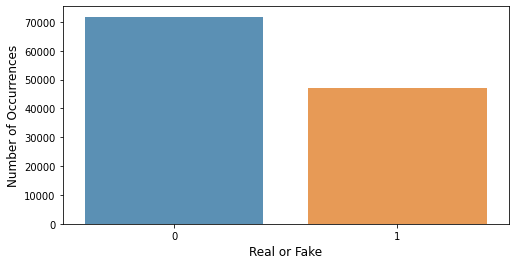

In [9]:
plt.figure(figsize=(8,4))
sns.barplot(cnt_labels.index, cnt_labels.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Real or Fake', fontsize=12)
plt.show()

We will now try to do feature engineering. This consists of two main parts 
1. meta features: features that we extract from the text like number of words, number of punctuations, etc 
2. text based features: features directly based on the text/words like frequency, svd, word2vec, etc. 

I referred to [this analysis](https://dacon.io/competitions/official/235658/codeshare/1917?page=1&dtype=recent&ptype=pub) for more feature engineering ideas 

In [10]:
mecab = Mecab()

In [11]:
train['title_tokenized'] = train['title'].apply(lambda x: mecab.morphs(x))

In [12]:
train['content_tokenized'] = train['content'].apply(lambda x: mecab.morphs(x))

In [13]:
test['title_tokenized'] = test['title'].apply(lambda x: mecab.morphs(x))
test['content_tokenized'] = test['content'].apply(lambda x: mecab.morphs(x))

In [14]:
# number of words in title
train['num_words_title'] = train['title_tokenized'].apply(lambda x: len(x)) 
test['num_words_title'] = test['title_tokenized'].apply(lambda x: len(x))   

# number of words in content 
train['num_words_content'] = train['content_tokenized'].apply(lambda x: len(x)) 
test['num_words_content'] = test['content_tokenized'].apply(lambda x: len(x)) 

In [15]:
# number of unique words in title 
train['title_num_unique'] = train['title_tokenized'].apply(lambda x: len(set(x))) 
test['title_num_unique'] = test['title_tokenized'].apply(lambda x: len(set(x))) 

# number of unique words in content 
train['content_num_unique'] = train['content_tokenized'].apply(lambda x: len(set(x))) 
test['content_num_unique'] = test['content_tokenized'].apply(lambda x: len(set(x))) 

In [16]:
# number of punctuations in text 
train['num_punctuations_title'] = train['title_tokenized'].apply(lambda x: len([c for c in x if c in string.punctuation]))
test['num_punctuations_title'] = test['title_tokenized'].apply(lambda x: len([c for c in x if c in string.punctuation]))

train['num_punctuations_content'] = train['content_tokenized'].apply(lambda x: len([c for c in x if c in string.punctuation]))
test['num_punctuations_content'] = test['content_tokenized'].apply(lambda x: len([c for c in x if c in string.punctuation]))

In [17]:
# [ 또는 (로 시작하는지에 대한 여부 
train["title_startswith_["]=train.title.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(")) 
train["content_startswith_["]=train.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") ) 
test["title_startswith_["]=test.title.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(")) 
test["content_startswith_["]=test.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") ) 


# ] 또는 )로 시작하는지에 대한 여부 
train["title_endswith_]"]=train.title.apply(lambda x : str(x).endswith("]" ) or str(x).endswith(")"))
train["content_endswith_]"]=train.content.apply(lambda x : str(x).endswith("]" ) or str(x).endswith(")") )
test["title_endswith_]"]=test.title.apply(lambda x : str(x).endswith("]" ) or str(x).endswith(")"))
test["content_endswith_]"]=test.content.apply(lambda x : str(x).endswith("]" ) or str(x).endswith(")") )


# ' 로 시작하는지에 대한 여부 
train["title_startswith_quote"]=train.title.apply(lambda x : str(x).startswith('"'))
train["content_startswith_quote"]=train.content.apply(lambda x : str(x).startswith('"'))
test["title_startswith_quote"]=test.title.apply(lambda x : str(x).startswith('"'))
test["content_startswith_quote"]=test.content.apply(lambda x : str(x).startswith('"'))


# '로 끝나는지에 대한 여부
train["title_endswith_quote"]=train.title.apply(lambda x : str(x).endswith('"'))
train["content_endswith_quote"]=train.content.apply(lambda x : str(x).endswith('"'))
test["title_endswith_quote"]=test.title.apply(lambda x : str(x).endswith('"'))
test["content_endswith_quote"]=test.content.apply(lambda x : str(x).endswith('"'))


# 숫자로 시작하는지에 대한 여부 
train["title_startswith_number"]=train.title.apply(lambda x : str(x)[0].isdigit())
train["content_startswith_number"]=train.content.apply(lambda x : str(x)[0].isdigit())
test["title_startswith_number"]=test.title.apply(lambda x : str(x)[0].isdigit())
test["content_startswith_number"]=test.content.apply(lambda x : str(x)[0].isdigit())


# 숫자로 끝나는지에 대한 여부 
train["title_endswith_number"]=train.title.apply(lambda x : str(x)[-1].isdigit())
train["content_endswith_number"]=train.content.apply(lambda x : str(x)[-1].isdigit())
test["title_endswith_number"]=test.title.apply(lambda x : str(x)[-1].isdigit())
test["content_endswith_number"]=test.content.apply(lambda x : str(x)[-1].isdigit())



In [18]:
# title length 
train["title_length"] = train['title'].apply(lambda x : len(x))
test["title_length"] = test['title'].apply(lambda x : len(x))

In [19]:
# content length 
train['content_length'] = train['content'].apply(lambda x: len(x))
test['content_length'] = test['content'].apply(lambda x: len(x))

In [20]:
# average length of word in title 
train['title_mean_length'] = train['title_tokenized'].apply(lambda x: np.mean([len(w) for w in x])) 
test['title_mean_length'] = test['title_tokenized'].apply(lambda x: np.mean([len(w) for w in x])) 

In [21]:
train.head()

,n_id,date,title,content,ord,info,title_tokenized,content_tokenized,num_words_title,num_words_content,...,content_startswith_quote,title_endswith_quote,content_endswith_quote,title_startswith_number,content_startswith_number,title_endswith_number,content_endswith_number,title_length,content_length,title_mean_length
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,"[[, 마감, ], 코스닥, 기관, 678, 억, 순매도]","[[, 이, 데일리, MARKETPOINT, ], 15, :, 32, 현재, 코스닥...",8,14,...,False,False,False,False,False,False,False,19,42,2.0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,"[[, 마감, ], 코스닥, 기관, 678, 억, 순매도]","["", 실적, 기반, "", 저, 가, 에, 매집, 해야, 할, 8, 월, 급등, 유...",8,18,...,True,False,False,False,False,False,False,19,37,2.0
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,"[[, 마감, ], 코스닥, 기관, 678, 억, 순매도]","[하이스, 탁론, ,, 선취, 수수료, 없, 는, 월, 0, ., 4, %, 최저,...",8,16,...,False,False,False,False,False,False,False,19,33,2.0
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,"[[, 마감, ], 코스닥, 기관, 678, 억, 순매도]","[종합, 경제, 정보, 미디어, 이, 데일리, -, 무단, 전재, &, 재, 배포,...",8,13,...,False,False,False,False,False,False,False,19,32,2.0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,"[롯데, ·, 공영, 등, 7, 개, TV, 홈, 쇼핑, 들, ,, 동행, 세일, 동참]","[전국, 적, 인, 소비, 붐, 조성, 에, 기여, 할, 예정]",14,10,...,False,False,False,False,False,False,False,27,20,1.5


In [22]:
test.head()

,n_id,date,title,content,ord,id,title_tokenized,content_tokenized,num_words_title,num_words_content,...,content_startswith_quote,title_endswith_quote,content_endswith_quote,title_startswith_number,content_startswith_number,title_endswith_number,content_endswith_number,title_length,content_length,title_mean_length
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1,"[[, 주목, !, e, 스몰, 캡, ], 코, 세스, ,, 마이크, 로, LED,...","[마이크, 로, LED, TV, 장비, 양산, 돌입, -, 전방, 업체, 투자, 확...",18,21,...,False,False,False,False,False,False,False,35,48,1.666667
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2,"[[, 주목, !, e, 스몰, 캡, ], 코, 세스, ,, 마이크, 로, LED,...","[[, 이, 데일리, 김대웅, 기자, ], 반도체, 장비, 업체, 코, 세스, (,...",18,33,...,False,False,False,False,False,False,False,35,76,1.666667
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3,"[[, 주목, !, e, 스몰, 캡, ], 코, 세스, ,, 마이크, 로, LED,...","[최근, 대형, 업체, 들, 과, 거래, 를, 맺, 고, 관련, 장비, 들, 의, ...",18,28,...,False,False,False,False,False,False,False,35,56,1.666667
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4,"[[, 주목, !, e, 스몰, 캡, ], 코, 세스, ,, 마이크, 로, LED,...","[TV, 를, 필두, 로, 올해, 부터, 마이크, 로, LED, 의, 시대, 가, ...",18,37,...,False,False,False,False,False,False,False,35,76,1.666667
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5,"[[, 주목, !, e, 스몰, 캡, ], 코, 세스, ,, 마이크, 로, LED,...","[코, 세스, 는, 반도체, 장비, 를, 제조, ,, 판매, 하, 는, 업체, 로,...",18,48,...,False,False,False,False,False,False,False,35,102,1.666667


In [23]:
train.shape, test.shape

((118745, 29), (142565, 29))

### Extract Text Based Features

Extract TF-IDF 1-3 ngram features

In [24]:
def mecab_tokenizer(text):  
    tokens_mecab = mecab.morphs(text) 
    return tokens_mecab

In [25]:
# used for singular value decomposition  
tfidf_vec = TfidfVectorizer(tokenizer = mecab_tokenizer, ngram_range = (1,3)) 
full_tfidf_title = tfidf_vec.fit_transform(train['title'].values.tolist() + test['title'].values.tolist())
train_tfidf_title = tfidf_vec.transform(train['title'].values.tolist()) 
test_tfidf_title = tfidf_vec.transform(test['title'].values.tolist())

In [26]:
full_tfidf_title.shape, train_tfidf_title.shape, test_tfidf_title.shape 

((261310, 170537), (118745, 170537), (142565, 170537))

In [27]:
# used for singular value decomposition  
tfidf_vec = TfidfVectorizer(tokenizer = mecab_tokenizer, ngram_range = (1,3)) 
full_tfidf_content = tfidf_vec.fit_transform(train['content'].values.tolist() + test['content'].values.tolist())
train_tfidf_content = tfidf_vec.transform(train['content'].values.tolist()) 
test_tfidf_content = tfidf_vec.transform(test['content'].values.tolist())

In [28]:
full_tfidf_content.shape, train_tfidf_content.shape, test_tfidf_content.shape 

((261310, 2465227), (118745, 2465227), (142565, 2465227))

In [29]:
svd_obj = TruncatedSVD(n_components = 20, algorithm = 'arpack') 
svd_obj.fit(full_tfidf_title)
train_svd_title = pd.DataFrame(svd_obj.transform(train_tfidf_title)) 
test_svd_title = pd.DataFrame(svd_obj.transform(test_tfidf_title))

In [30]:
train_svd_title.columns = ['svd_word_title_' + str(i) for i in range(20)] 
test_svd_title.columns = ['svd_word_title_' + str(i) for i in range(20)] 

train = pd.concat([train, train_svd_title], axis = 1) 
test = pd.concat([test, test_svd_title], axis = 1)  

del full_tfidf_title, train_tfidf_title, test_tfidf_title, train_svd_title, test_svd_title

In [31]:
svd_obj = TruncatedSVD(n_components = 20, algorithm = 'arpack') 
svd_obj.fit(full_tfidf_content) 
train_svd_content = pd.DataFrame(svd_obj.transform(train_tfidf_content)) 
test_svd_content = pd.DataFrame(svd_obj.transform(test_tfidf_content)) 

In [32]:
train_svd_content.columns = ['svd_word_content_' + str(i) for i in range(20)] 
test_svd_content.columns = ['svd_word_content_' + str(i) for i in range(20)] 

train = pd.concat([train, train_svd_content], axis = 1) 
test = pd.concat([test, test_svd_content], axis = 1)  

del full_tfidf_content, train_tfidf_content, test_tfidf_content, train_svd_content, test_svd_content

In [33]:
train.shape, test.shape 

((118745, 69), (142565, 69))

In [48]:
x_train = train.drop(['n_id','info', 'title', 'content', 'title_tokenized', 'content_tokenized'],axis=1) 
y_train = train['info']

In [49]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [50]:
x_test = test.drop(['n_id','id','title', 'content', 'title_tokenized', 'content_tokenized'],axis=1)

In [51]:
x_test = np.asarray(x_test)

In [52]:
x_train.shape, y_train.shape, x_test.shape

((118745, 63), (118745,), (142565, 63))

we will begin training at this step, but to make our dataset stronger, we can add predictions from other models to our list of features as well. For example, we can use count vectorizer to extract word count information from the corpus and fit and predict using multinomial NB, then add the predicted results to our dataset and so on. 

In [54]:
k = 5 
models = [] 
kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = 990101) 
for n_fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)): 
    train_x, val_x = x_train[train_idx], x_train[val_idx]
    train_y, val_y = y_train[train_idx], y_train[val_idx] 
    
    params = {'learning_rate': 0.01,
              'max_depth': 16, 
              'objective': 'binary',
              'metric': 'binary_logloss',
              'is_training_metric': True,
              'num_leaves': 128,
              'feature_fraction': 0.9,
              'bagging_fraction': 0.75, 
              'bagging_freq': 5,
              'seed': 960418} 
    
    train_ds = lgbm.Dataset(train_x, label = train_y) 
    val_ds = lgbm.Dataset(val_x, label = val_y) 
    model = lgbm.train(params, train_ds, 1000, val_ds, verbose_eval = 10, early_stopping_rounds = 100) 
    models.append(model) 

[LightGBM] [Info] Number of positive: 37546, number of negative: 57450
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11473
[LightGBM] [Info] Number of data points in the train set: 94996, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395238 -> initscore=-0.425348
[LightGBM] [Info] Start training from score -0.425348
Training until validation scores don't improve for 100 rounds
[10]	valid_0's binary_logloss: 0.589135
[20]	valid_0's binary_logloss: 0.52097
[30]	valid_0's binary_logloss: 0.464232
[40]	valid_0's binary_logloss: 0.415491
[50]	valid_0's binary_logloss: 0.373814
[60]	valid_0's binary_logloss: 0.337826
[70]	valid_0's binary_logloss: 0.306447
[80]	valid_0's binary_logloss: 0.279052
[90]	valid_0's binary_logloss: 0.254734
[100]	valid_0's b

[690]	valid_0's binary_logloss: 0.0264561
[700]	valid_0's binary_logloss: 0.0261684
[710]	valid_0's binary_logloss: 0.0258538
[720]	valid_0's binary_logloss: 0.0255845
[730]	valid_0's binary_logloss: 0.0253361
[740]	valid_0's binary_logloss: 0.0250834
[750]	valid_0's binary_logloss: 0.0248246
[760]	valid_0's binary_logloss: 0.0245935
[770]	valid_0's binary_logloss: 0.0243232
[780]	valid_0's binary_logloss: 0.0241029
[790]	valid_0's binary_logloss: 0.023888
[800]	valid_0's binary_logloss: 0.0236639
[810]	valid_0's binary_logloss: 0.0234545
[820]	valid_0's binary_logloss: 0.0232634
[830]	valid_0's binary_logloss: 0.0229961
[840]	valid_0's binary_logloss: 0.0228175
[850]	valid_0's binary_logloss: 0.0226524
[860]	valid_0's binary_logloss: 0.0224915
[870]	valid_0's binary_logloss: 0.0223084
[880]	valid_0's binary_logloss: 0.0221172
[890]	valid_0's binary_logloss: 0.0219433
[900]	valid_0's binary_logloss: 0.0218131
[910]	valid_0's binary_logloss: 0.0216097
[920]	valid_0's binary_logloss: 0.0

[330]	valid_0's binary_logloss: 0.0584622
[340]	valid_0's binary_logloss: 0.0562787
[350]	valid_0's binary_logloss: 0.0542773
[360]	valid_0's binary_logloss: 0.0524449
[370]	valid_0's binary_logloss: 0.0507168
[380]	valid_0's binary_logloss: 0.0491455
[390]	valid_0's binary_logloss: 0.0476881
[400]	valid_0's binary_logloss: 0.0463665
[410]	valid_0's binary_logloss: 0.045127
[420]	valid_0's binary_logloss: 0.0439906
[430]	valid_0's binary_logloss: 0.0428791
[440]	valid_0's binary_logloss: 0.0418763
[450]	valid_0's binary_logloss: 0.0408834
[460]	valid_0's binary_logloss: 0.0399612
[470]	valid_0's binary_logloss: 0.0391164
[480]	valid_0's binary_logloss: 0.0383429
[490]	valid_0's binary_logloss: 0.0375649
[500]	valid_0's binary_logloss: 0.036826
[510]	valid_0's binary_logloss: 0.0361775
[520]	valid_0's binary_logloss: 0.0355279
[530]	valid_0's binary_logloss: 0.0348988
[540]	valid_0's binary_logloss: 0.0343827
[550]	valid_0's binary_logloss: 0.0338415
[560]	valid_0's binary_logloss: 0.03

In [61]:
# make predictions 
pred1 = models[0].predict(x_test)
pred2 = models[1].predict(x_test)
pred3 = models[2].predict(x_test) 
pred4 = models[3].predict(x_test) 
pred5 = models[4].predict(x_test)

In [62]:
pred_avg = (pred1 + pred2 + pred3 + pred4 + pred5)/5.0 

In [65]:
class_pred = np.where(pred_avg > 0.5, 1, 0).reshape(-1)

In [67]:
submission['info'] = class_pred

In [68]:
submission.head()

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0


In [69]:
submission.to_csv('lightgbm_63_features.csv',index=False)